In [ ]:
import json
import torch
from tqdm import tqdm
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from jiwer import wer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_FILE = 'spoken_train-v1.1.json'
TEST_FILE = 'spoken_test-v1.1.json'

In [ ]:
MAX_LEN = 512
MODEL_PATH = "rein5/bert-base-uncased-finetuned-spoken-squad"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.01
EPOCHS = 5
losses, f1_scores, accuracy_scores, wer_scores = [], [], [], []
best_loss = float('inf')

In [ ]:
def load_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    contexts, questions, answers = [], [], []
    for section in data['data']:
        for paragraph in section['paragraphs']:
            context = paragraph['context'].lower()
            for qa in paragraph['qas']:
                question = qa['question'].lower()
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    return contexts, questions, answers

train_contexts, train_questions, train_answers = load_data(TRAIN_FILE)
valid_contexts, valid_questions, valid_answers = load_data(TEST_FILE)

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_PATH).to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

train_steps = len(train_contexts) * 5

In [ ]:
def extend_answer_end(answers, contexts):
    for answer, context in zip(answers, contexts):
        answer['text'] = answer['text'].lower()
        answer['answer_end'] = answer['answer_start'] + len(answer['text'])

extend_answer_end(train_answers, train_contexts)
extend_answer_end(valid_answers, valid_contexts)

In [ ]:
train_encodings = tokenizer(train_contexts, train_questions, max_length=MAX_LEN, truncation=True, padding=True)
valid_encodings = tokenizer(valid_contexts, valid_questions, max_length=MAX_LEN, truncation=True, padding=True)

In [ ]:
class QandADataset(Dataset):
    def __init__(self, encodings, answers):
        self.encodings = encodings
        self.answers = answers
        self.start_pos, self.end_pos = self._find_positions()

    def _find_positions(self):
        start_pos, end_pos = [], []
        for answer, ids in zip(self.answers, self.encodings['input_ids']):
            start_pos.append(answer['answer_start'])
            end_pos.append(answer['answer_end'])
        return start_pos, end_pos

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'start_positions': torch.tensor(self.start_pos[idx]),
            'end_positions': torch.tensor(self.end_pos[idx])
        }

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = QandADataset(train_encodings, train_answers)
valid_dataset = QandADataset(valid_encodings, valid_answers)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1)

In [ ]:
def train_model(model, dataloader):
    model.train()
    epoch_loss = 0
    for batch in tqdm(dataloader, desc='Training'):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'start_positions' and k != 'end_positions'}
        labels = { 'start_positions': batch['start_positions'].to(device), 'end_positions': batch['end_positions'].to(device)}
        outputs = model(**inputs, **labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    pred_answers, true_answers = [], []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            start_pred = torch.argmax(outputs.start_logits, dim=1)
            end_pred = torch.argmax(outputs.end_logits, dim=1)

            answer = tokenizer.decode(input_ids[0][start_pred:end_pred + 1], skip_special_tokens=True).strip()
            pred_answers.append(answer)

            true_answer = tokenizer.decode(input_ids[0][batch['start_positions']:batch['end_positions']], skip_special_tokens=True).strip()
            true_answers.append(true_answer)

    filtered_pred_answers = [pred for pred, true in zip(pred_answers, true_answers) if true]
    filtered_true_answers = [true for true in true_answers if true]

    wer_score = wer(filtered_true_answers, filtered_pred_answers)
    return pred_answers, true_answers, wer_score

In [ ]:
def compute_wer(true_answers, predicted_answers):
    errors = [wer(t, p) for t, p in zip(true_answers, predicted_answers)]
    return sum(errors) / len(errors)

In [ ]:
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader)
    pred_answers, true_answers, wer_score = evaluate_model(model, valid_loader)  # Unpacking three values
    
    f1 = f1_score([a == b for a, b in zip(pred_answers, true_answers)], [True] * len(pred_answers))
    accuracy = accuracy_score([a == b for a, b in zip(pred_answers, true_answers)], [True] * len(pred_answers))
    
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    losses.append(train_loss)
    wer_scores.append(wer_score)
    
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}, WER: {wer_score:.4f}")

print(f'\nFinal F1 Score: {f1_scores[-1]:.4f}, Accuracy: {accuracy_scores[-1]:.4f}, WER: {wer_scores[-1]:.4f}')

Evaluating: 100%|██████████| 15875/15875 [01:29<00:00, 176.98it/s]


Epoch 1 - Train Loss: 5.8661, F1 Score: 0.6390, Accuracy: 0.4695, WER: 2.2692


Evaluating: 100%|██████████| 15875/15875 [01:29<00:00, 177.33it/s]


Epoch 2 - Train Loss: 5.0872, F1 Score: 0.5764, Accuracy: 0.4049, WER: 1.8310


Evaluating: 100%|██████████| 15875/15875 [01:28<00:00, 178.90it/s]


Epoch 3 - Train Loss: 4.4281, F1 Score: 0.7079, Accuracy: 0.5479, WER: 1.2609


Evaluating: 100%|██████████| 15875/15875 [01:28<00:00, 178.97it/s]


Epoch 4 - Train Loss: 4.0077, F1 Score: 0.7008, Accuracy: 0.5395, WER: 1.0533


Evaluating: 100%|██████████| 15875/15875 [01:28<00:00, 178.96it/s]


Epoch 5 - Train Loss: 3.7205, F1 Score: 0.6969, Accuracy: 0.5348, WER: 1.0530

Final F1 Score: 0.6969, Accuracy: 0.5348, WER: 1.0530


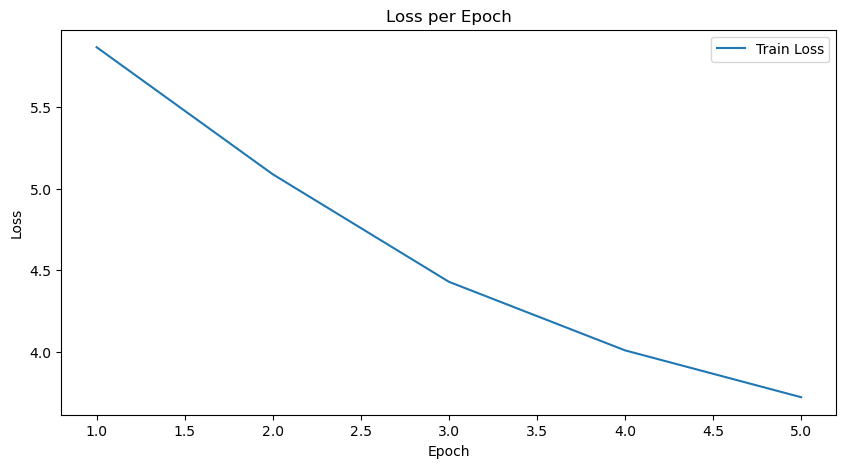

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

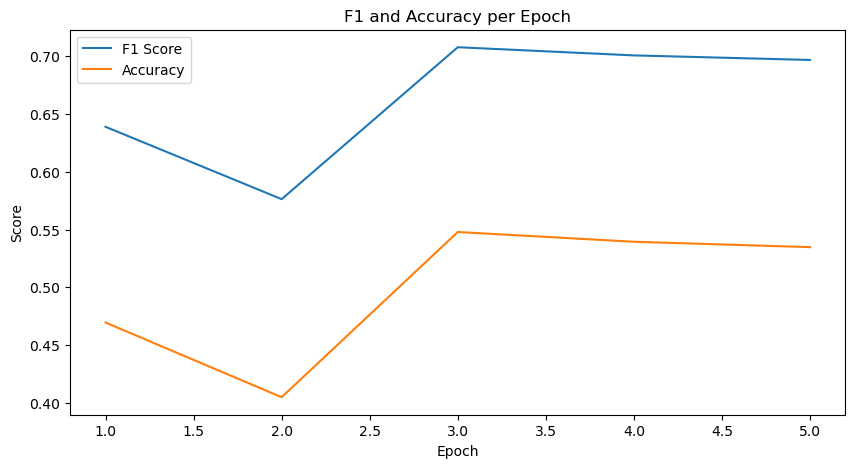

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, label="F1 Score")
plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("F1 and Accuracy per Epoch")
plt.legend()
plt.show()